In [1]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
def printCompasDetails(data, *seeds, mask=()):
    """
    Function to print the full Compas output for given seeds, optionally with an additional mask
    """
    list_of_keys = list(data.keys())

    # Check if seed parameter exists - if not, just print without (e.g RunDetails)
    if ('SEED' in list_of_keys) | ('SEED>MT' in list_of_keys): # Most output files 
        #SEED>MT is a relic from older versions, but we leave this in for backwards compatibility

        # Set the seed name parameter, mask on seeds as needed, and set the index
        seedVariableName='SEED' if ('SEED' in list_of_keys) else 'SEED>MT'
        list_of_keys.remove(seedVariableName) # this is the index above, don't want to include it
    
        allSeeds = data[seedVariableName][()]
        seedsMask = np.in1d(allSeeds, seeds)
        if len(seeds) == 0: # if any seed is included, do not reset the mask
            seedsMask = np.ones_like(allSeeds).astype(bool)
        if mask == ():
            mask = np.ones_like(allSeeds).astype(bool)
        mask &= seedsMask

        df = pd.DataFrame.from_dict({param: data[param][()][mask] for param in list(data.keys())}).set_index(seedVariableName).T

    else: # No seed parameter, so do custom print for Run Details

        # Get just the keys without the -Derivation suffix - those will be a second column
        keys_not_derivations = []
        for key in list_of_keys:
            if '-Derivation' not in key:
                keys_not_derivations.append(key)
        
        # Some parameter values are string types, formatted as np.bytes_, need to convert back
        def convert_strings(param_array):
            if isinstance(param_array[0], np.bytes_):
                return param_array.astype(str)
            else:
                return param_array

        df_keys = pd.DataFrame.from_dict({param: convert_strings(data[param][()]) for param in keys_not_derivations }).T
        nCols = df_keys.shape[1] # Required only because if we combine RDs, we get many columns (should fix later)
        df_keys.columns = ['Parameter']*nCols
        df_drvs = pd.DataFrame.from_dict({param: convert_strings(data[param+'-Derivation'][()]) for param in keys_not_derivations }).T
        df_drvs.columns = ['Derivation']*nCols
        df = pd.concat([df_keys, df_drvs], axis=1)

    # Add units as first col
    units_dict = {key:data[key].attrs['units'].astype(str) for key in list_of_keys}
    df.insert(loc=0, column='(units)', value=pd.Series(units_dict))
    return df


In [3]:
def stellar_types_histogram(data):

    bins = np.arange(0, 16 + 1.5) - 0.5
    xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    
    SPs = data["BSE_System_Parameters"]

    zams_type_primary = np.array(SPs['Stellar_Type@ZAMS(1)'][()])
    zams_type_secundary = np.array(SPs['Stellar_Type@ZAMS(2)'][()])

    term_type_primary = np.array(SPs['Stellar_Type(1)'][()])
    term_type_secundary = np.array(SPs['Stellar_Type(2)'][()])
    
    fig, ax = plt.subplots(2,2, figsize=(14,10))
    
    ax[0][0].set_title("Stellar Types at ZAMS")
    
    counts00, edges00, bars00 = ax[0][0].hist(zams_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[0][0].set_ylabel("Amount")
    ax[0][0].set_xticks(xtix)
    ax[0][0].legend()
    ax[0][0].set_xlabel("Stellar Types")
    ax[0][0].bar_label(bars00)
    
    counts01, edges01, bars01 = ax[0][1].hist(zams_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[0][1].set_ylabel("Amount")
    ax[0][1].set_xticks(xtix)
    ax[0][1].legend()
    ax[0][1].set_xlabel("Stellar Types")
    ax[0][1].bar_label(bars01)
    
    ax[1][0].set_title("Final Stellar Types")
    
    counts10, edges10, bars10 = ax[1][0].hist(term_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[1][0].set_ylabel("Amount")
    ax[1][0].set_xticks(xtix)
    ax[1][0].legend()
    ax[1][0].bar_label(bars10)
    
    counts11, edges11, bars11 = ax[1][1].hist(term_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[1][1].set_ylabel("Amount")
    ax[1][1].set_xticks(xtix)
    ax[1][1].legend()
    ax[1][1].bar_label(bars11)
    ax[1][1].set_xlabel("Stellar Types")
    
    plt.show()

In [4]:
# set path to data file
path = '/home/louism/Thesis/data/COMPAS_Output_CE/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

In [6]:
CE = data['BSE_Common_Envelopes']
SLs = data['BSE_Switch_Log']
SPs = data['BSE_System_Parameters']

In [7]:
primary_donor_mask = (SPs['MT_Donor_Hist(1)'][()] != b'NA              ')
secondary_donor_mask = (SPs['MT_Donor_Hist(2)'][()]!= b'NA              ')

primary_donor_masses = SPs['Mass@ZAMS(1)'][primary_donor_mask]
secondary_donor_masses = SPs['Mass@ZAMS(2)'][secondary_donor_mask]

In [8]:
def getTimeStripped(seed, PrimarySecondary):
    
    sls = printCompasDetails(SLs, seed)
    sls_data = np.array(sls.to_numpy())
    sls_data = sls_data[:, 1:].astype(float)
    primary_mask = sls_data[0][()] == 1
    secondary_mask = sls_data[0][()] == 2
    stripped_mask1 = sls_data[2][primary_mask] >= 7
    stripped_mask2 = sls_data[2][secondary_mask] >= 7
    if PrimarySecondary == 1:
        time = sls_data[3][primary_mask][stripped_mask1][-1]-sls_data[3][primary_mask][stripped_mask1][0]
    if PrimarySecondary == 2:
        time = sls_data[3][secondary_mask][stripped_mask2][-1]-sls_data[3][secondary_mask][stripped_mask2][0]
    return time

In [28]:
def MassVsTimeSpentStripped(seeds, PrimarySecondary):

    time = []
    
    for seed in seeds:
        time.append(getTimeStripped(seed, PrimarySecondary))
        
    return [time, SPs['Stellar_Type(1)<CE'][primary_donor_mask], SPs['Stellar_Type(1)>CE'][primary_donor_mask]]

In [29]:
to_plot1 = MassVsTimeSpentStripped(SPs['SEED'][primary_donor_mask], 1)
#to_plot2 = MassVsTimeSpentStripped(SPs['SEED'][secondary_donor_mask], 2)

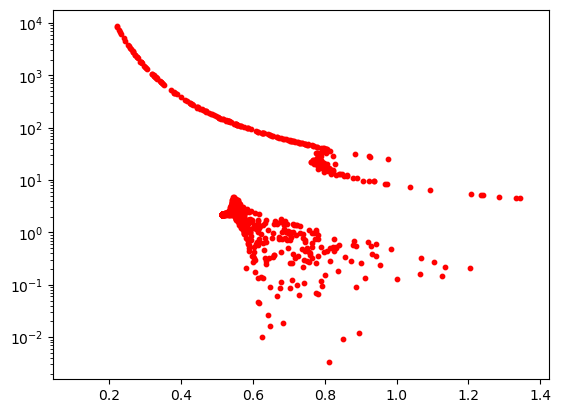

In [30]:
plt.scatter(SPs['Mass(1)>CE'][primary_donor_mask], to_plot1[0], color='red', s=10, marker='o')
#plt.scatter(to_plot2[2], to_plot2[0], color='red', s=10, marker='o')

plt.yscale('log')

In [31]:
to_plot1[1]

array([ 5, 10,  7, ...,  3,  5,  7], dtype=int32)

In [33]:
bins = np.arange(0, 16 + 1.5) - 0.5
xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

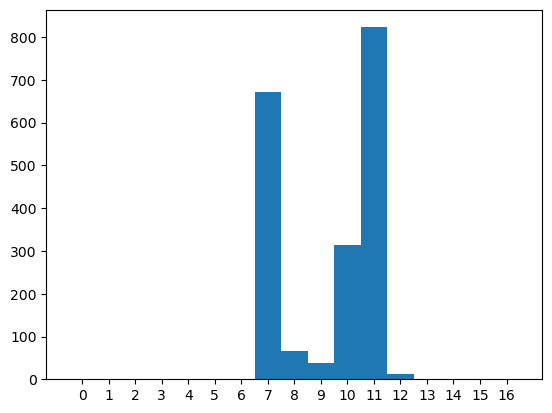

In [66]:
plt.hist(SPs['Stellar_Type(1)'][primary_donor_mask], bins)
plt.xticks(xtix)
plt.show()

In [58]:
stripped_as_map = {3: 'yellow',
             4 : 'orange',       
             5 : 'green',
             6 : 'purple',
             7 : 'blue',
             10 : 'red',
             11: 'red',
             12: 'red'
            }

stripped_to_map = {7: 'yellow',
             8 : 'orange',       
             9 : 'green',
             10 : 'red',
             11 : 'red',
             12 : 'red',
            }

In [71]:
legend_elements_stripped_as = [
                               plt.Line2D([0], [0], marker='o', color='w',label='FGB', markerfacecolor='yellow', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='CHeB', markerfacecolor='orange', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='EAGB', markerfacecolor='green', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='EAGB', markerfacecolor='purple', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='HeMS', markerfacecolor='blue', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='CO', markerfacecolor='red', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='CO', markerfacecolor='red', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='CO', markerfacecolor='red', markersize=10)
                                ]

legend_elements_stripped_to = [
                               plt.Line2D([0], [0], marker='o', color='w',label='HeMS', markerfacecolor='yellow', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='HeHG', markerfacecolor='orange', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='HeGB', markerfacecolor='green', markersize=10),
                               plt.Line2D([0], [0], marker='o', color='w',label='CO', markerfacecolor='red', markersize=10),
                                ]

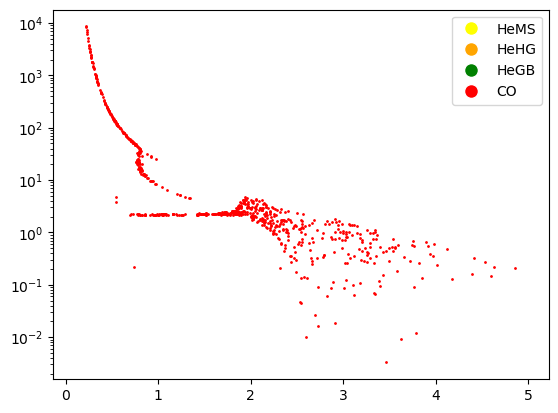

In [72]:
for i in range(len(SPs['Mass(1)>CE'][primary_donor_mask])):
    plt.scatter( SPs['Mass(1)<CE'][primary_donor_mask][i], to_plot1[0][i],
                color = stripped_to_map[SPs['Stellar_Type(1)'][primary_donor_mask][i]],
                s = 1
               )

plt.legend(handles=legend_elements_stripped_to, loc='best')

plt.yscale('log')

plt.show()